In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
secciones = gpd.read_file("SHAPEFILE/SECCION.shp")
censo = pd.read_csv("Dataton_2024/data/INE_SECCION_2020.csv")
pib_data_raw = pd.read_csv('Dataton_2024/data/PIBE_2.csv')

DataSourceError: SHAPEFILE/SECCION.shp: No such file or directory

In [3]:
pib_data = pib_data_raw.iloc[6:38]
pib_data = pib_data.iloc[:, [0] + list(range(15,20))]
pib_data.iloc[:, 15:20].astype(float)
pib_data = pib_data.rename(columns = {"Concepto":"Nom_Entidad", "2020 R":"2020", "2021 P":"2021"})
pib_data = pib_data.reset_index(drop = True) 
pib_data.index = pib_data.index 
pib_data["PROMEDIO_PIB"] = pib_data.drop("Nom_Entidad", axis=1, errors='ignore').mean(axis = 1)
pib_data["ENTIDAD"] = pib_data.index + 1

Text(0.65, 0.01, 'Fuente: Elaboración propia con datos sobre Comercio al por menor, DENUE (INEGI), 2024')

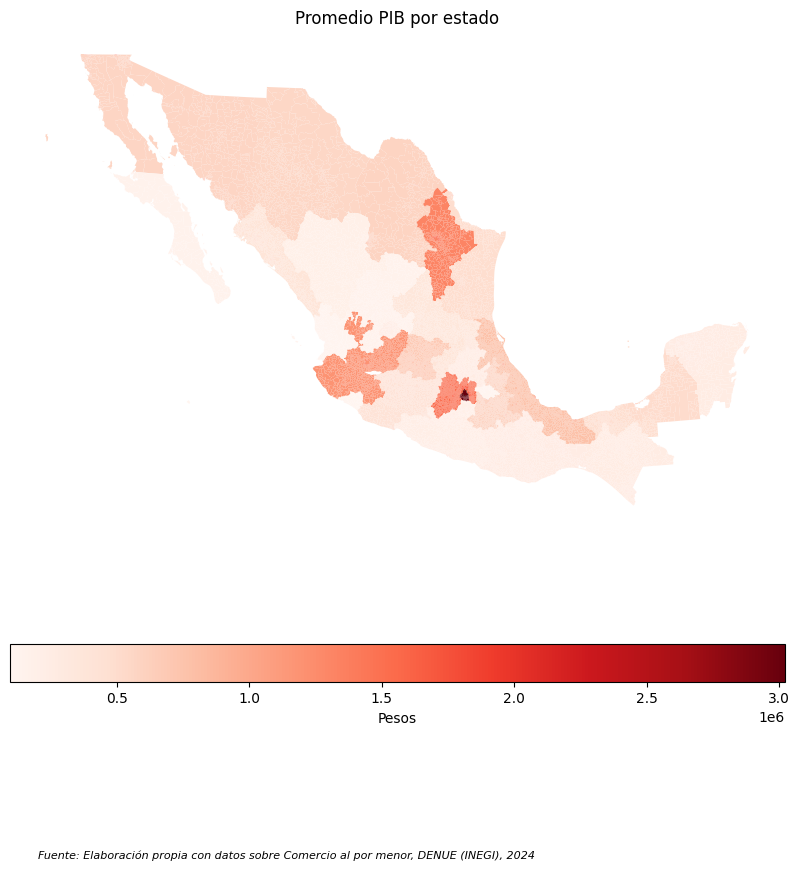

In [4]:
########################################################################################
################################ PROMEDIO PIB POR ESTADO ###############################
########################################################################################

pib_data_merged = pib_data.merge(secciones, left_on=['ENTIDAD'], right_on=['ENTIDAD'])
pib_data_merged = gpd.GeoDataFrame(pib_data_merged, geometry='geometry')

#print(pib_data_merged.columns)

fig, ax = plt.subplots(figsize=(10, 10))
pib_data_merged.plot(column='PROMEDIO_PIB', cmap='Reds', legend=True, 
                     ax=ax, linewidth=0.1, legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title('Promedio PIB por estado')
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')


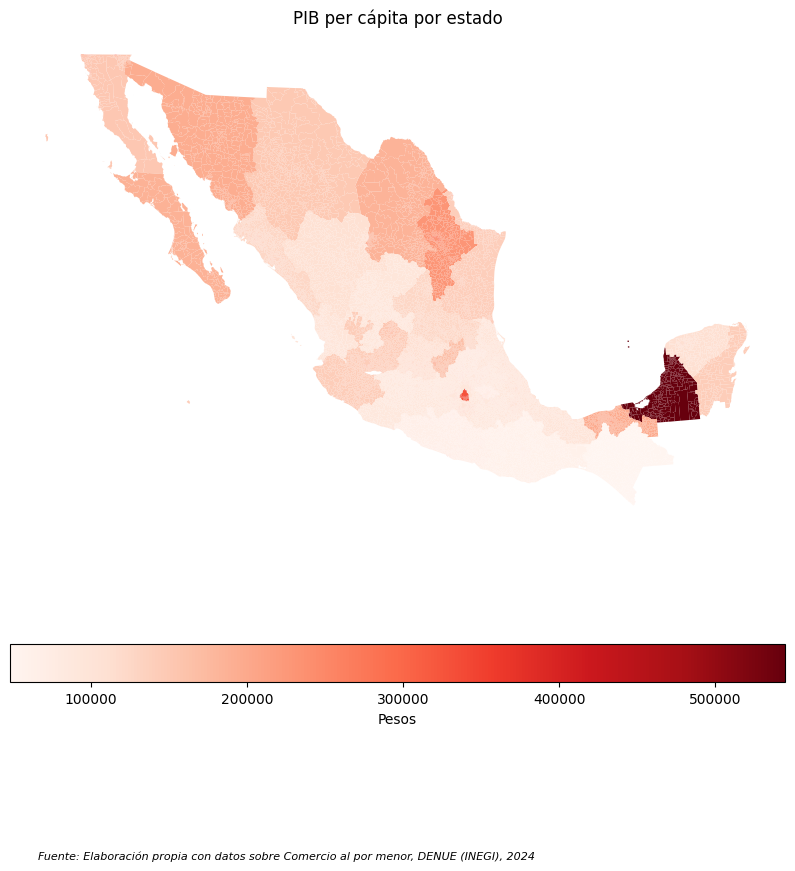

In [5]:
########################################################################################
############################### PIB PÉR CAPITA POR ESTADO ##############################
########################################################################################

#leemos el archivo donde se encuentra la poblacion por entidad federativa
population_data = pd.read_csv('population_data.csv')

#pasamos los datos de poblacion de str a tipo numerico
population_data['2020'] = pd.to_numeric(population_data['2020'].str.replace(',', ''))

pib_poblacion_merged = pib_data.merge(population_data, on='Nom_Entidad')

#Se calcula el PIB per capita usando ambos archivos csv (pibe_2 y population_data)
pib_poblacion_merged['PIB_PER_CAPITA'] = pib_poblacion_merged['PROMEDIO_PIB']*(1000000)/population_data['2020']

#Fusionamos las secciones y convertimos a GeoDataFrame
pib_data_merged = pib_poblacion_merged.merge(secciones, on='ENTIDAD')
pib_data_merged = gpd.GeoDataFrame(pib_data_merged, geometry='geometry')

#Graficamos el mapa de Mexico con el pib per capita por estado 
fig, ax = plt.subplots(figsize=(10, 10))
pib_data_merged.plot(column='PIB_PER_CAPITA', cmap='Reds', legend=True, 
                     ax=ax, linewidth=0.1,
                     legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()

plt.title('PIB per cápita por estado')
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()

pib_data["PIB_PER_CAPITA"] = pib_data.drop("Nom_Entidad", axis=1, errors='ignore').mean(axis = 1)


In [6]:
#obtenemos una lista de los estados con mayor PIB pér cápita
sorted_pib = pib_poblacion_merged.sort_values(by='PIB_PER_CAPITA', ascending=False)
print(sorted_pib[['Nom_Entidad', 'PIB_PER_CAPITA']])

                        Nom_Entidad  PIB_PER_CAPITA
3                          Campeche   544825.691459
8                  Ciudad de México   328045.805664
18                       Nuevo León   229766.582844
26                          Tabasco   199136.688035
25                           Sonora   194308.611537
2               Baja California Sur   186263.815382
4              Coahuila de Zaragoza   185398.900714
21                        Querétaro   165474.049501
1                   Baja California   151123.351110
0                    Aguascalientes   150894.838199
7                         Chihuahua   149361.524682
22                     Quintana Roo   143026.564047
5                            Colima   141847.226723
13                          Jalisco   141697.307320
27                       Tamaulipas   140581.089112
24                          Sinaloa   127045.382354
23                  San Luis Potosí   126819.810612
10                       Guanajuato   111966.100724
30          

In [7]:
#########################################################################################################################################
#########################################################################################################################################
################### A CONTINUACIÓN, SE PRESENTAN LOS ESTADOS CON MAYOR PIB PER CAPITA POR ENTIDAD FEDERATIVA ############################
#########################################################################################################################################
#########################################################################################################################################

C:\Users\Mariela Mejia\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


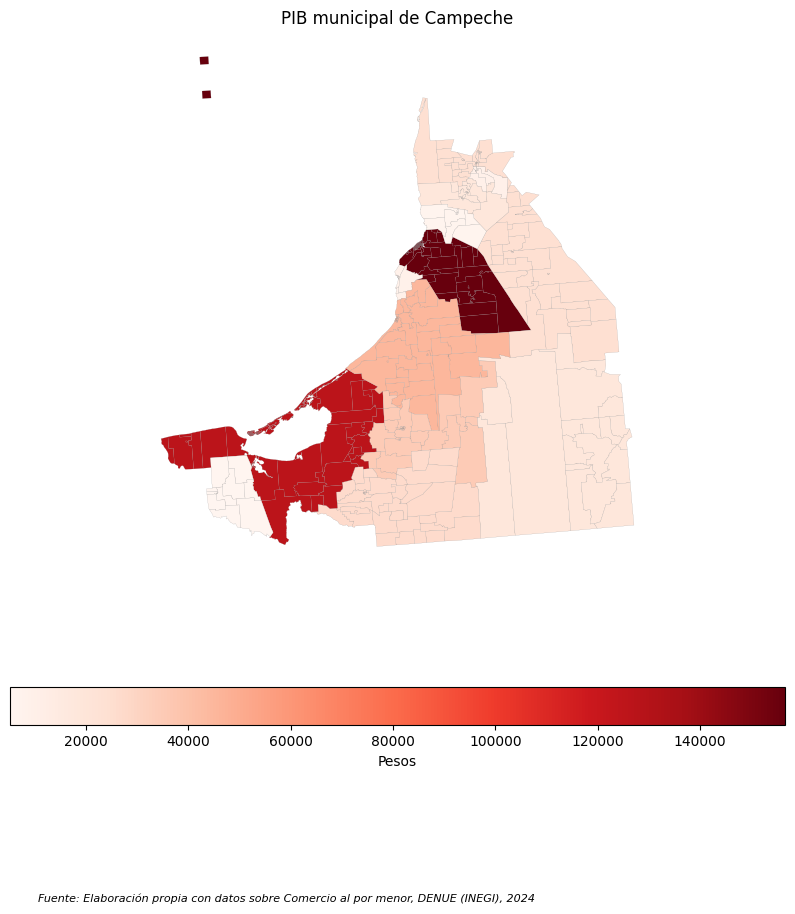

In [8]:
###############################################################################################
############################# PIB PÉR CÁPITA MUNICIPAL DE CAMPECHE ############################
###############################################################################################
###############################################################################################
### PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal ###
###############################################################################################

#obtenemos la entidad federativa
camp = secciones[secciones['ENTIDAD'] == 4] #Campeche

#obtenemos los datos unicamente de Campeche
campeche = pib_data[pib_data['Nom_Entidad'] == 'Campeche']
#obtenemos el PIB estatal 
pib_campeche = campeche['PROMEDIO_PIB'] 

camp['ENTIDAD'] = camp['ENTIDAD'].astype(str)
censo['ENTIDAD'] = censo['ENTIDAD'].astype(str)

camp_w_vars = camp.merge(censo, left_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'], right_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'])
#obtenemos poblacion municipal
poblacion_municipal = camp_w_vars.groupby('MUNICIPIO')['POBTOT'].sum().reset_index()
poblacion_municipal  = poblacion_municipal.rename(columns = {"POBTOT":"pobMunicipio"})

camp_w_vars = camp_w_vars.merge(poblacion_municipal, on='MUNICIPIO', how='left')
#definimos la geometría del mapa
camp_w_vars = gpd.GeoDataFrame(camp_w_vars, geometry='geometry')

#obtenemos el PIB pér cápita municipal
### PIB pér cápita municipal = [(PIB estatal) / (población estatal )] * población municipal ###
camp_w_vars['mun_pib'] = (pib_campeche[3] / camp_w_vars['POBTOT'].sum())*camp_w_vars['pobMunicipio']
#Graficamos el PIB municipal de Campeche obtenido 
fig, ax = plt.subplots(figsize=(10, 10))
camp_w_vars.plot(column='mun_pib', ax=ax, cmap='Reds', legend=True, 
                 edgecolor='grey', linewidth=0.1,
                 legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB municipal de Campeche")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()

C:\Users\Mariela Mejia\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


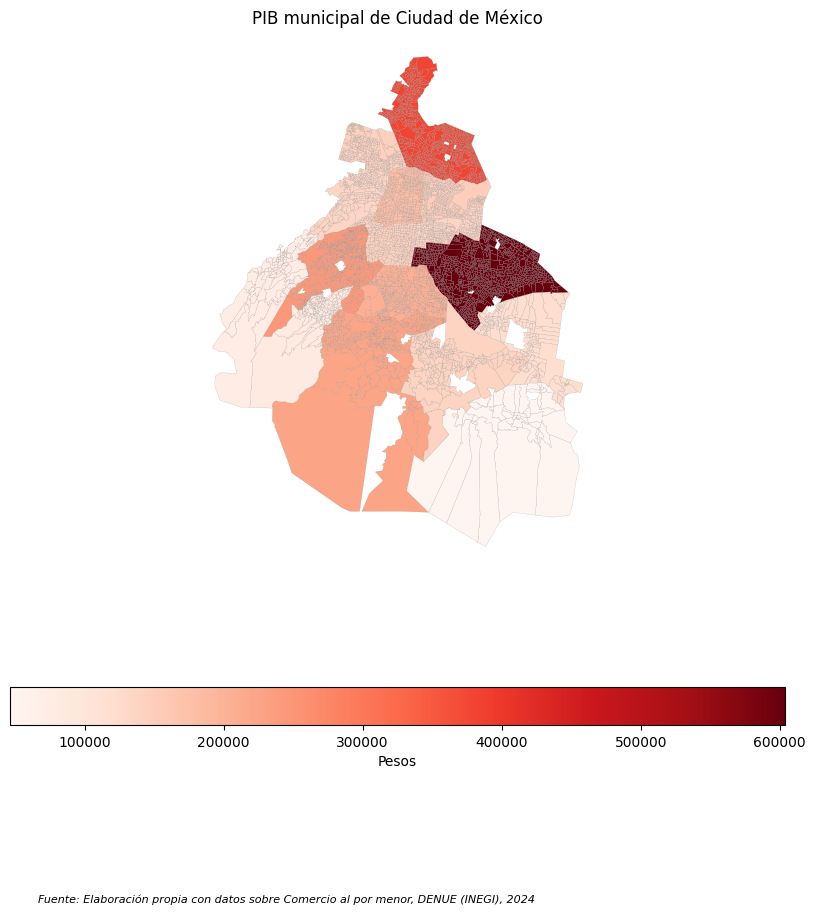

In [9]:
###############################################################################################
######################### PIB PÉR CÁPITA MUNICIPAL DE CIUDAD DE MÉXICO ########################
###############################################################################################
###############################################################################################
### PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal ###
###############################################################################################

#obtenemos la entidad federativa
cdmx =  secciones[secciones['ENTIDAD'] == 9] #Ciudad de Mexico

#obtenemos lis datos unicamente de Ciudad de México
cdMx = pib_data[pib_data['Nom_Entidad'] == 'Ciudad de México']
#obtenemos el PIB estatal 
pib_cdmx = cdMx['PROMEDIO_PIB'] 

cdmx['ENTIDAD'] = cdmx['ENTIDAD'].astype(str)
censo['ENTIDAD'] = censo['ENTIDAD'].astype(str)

cdmx_w_vars = cdmx.merge(censo, left_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'], right_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'])
#poblacion municipal
poblacion_municipal = cdmx_w_vars.groupby('MUNICIPIO')['POBTOT'].sum().reset_index()
poblacion_municipal  = poblacion_municipal.rename(columns = {"POBTOT":"pobMunicipio"})

cdmx_w_vars = cdmx_w_vars.merge(poblacion_municipal, on='MUNICIPIO', how='left')
#definimos la geometría del mapa
cdmx_w_vars = gpd.GeoDataFrame(cdmx_w_vars, geometry='geometry')

#obtenemos el PIB pér cápita municipal
### PIB pér cápita municipal = [(PIB estatal) / (población estatal )] * población municipal ###
cdmx_w_vars['mun_pib'] = (pib_cdmx[8] / cdmx_w_vars['POBTOT'].sum())*cdmx_w_vars['pobMunicipio']

#Graficamos el PIB municipal de Cdmx obtenido 
fig, ax = plt.subplots(figsize=(10, 10))
cdmx_w_vars.plot(column='mun_pib', ax=ax, cmap='Reds', legend=True, 
                 edgecolor='grey', linewidth=0.1,
                 legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB municipal de Ciudad de México")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()

C:\Users\Mariela Mejia\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


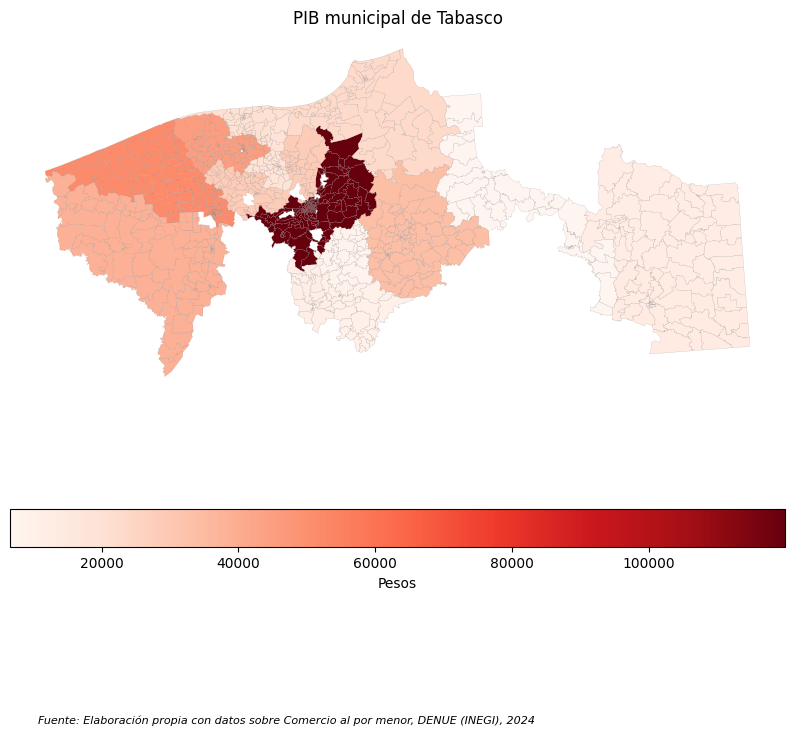

In [10]:
###############################################################################################
############################## PIB PÉR CÁPITA MUNICIPAL DE TABASCO ############################
###############################################################################################
###############################################################################################
### PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal ###
###############################################################################################

#obtenemos la entidad federativa
tabs = secciones[secciones['ENTIDAD'] == 27] #Tabasco

#obtenemos los datos de Tabasco
tabasco = pib_data[pib_data['Nom_Entidad'] == 'Tabasco']
#obtenemos el PIB estatal 
pib_tabasco = tabasco['PROMEDIO_PIB'] 

tabs['ENTIDAD'] = tabs['ENTIDAD'].astype(str)
censo['ENTIDAD'] = censo['ENTIDAD'].astype(str)

tabs_w_vars = tabs.merge(censo, left_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'], right_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'])
#poblacion municipal
poblacion_municipal = tabs_w_vars.groupby('MUNICIPIO')['POBTOT'].sum().reset_index()
poblacion_municipal  = poblacion_municipal.rename(columns = {"POBTOT":"pobMunicipio"})


tabs_w_vars = tabs_w_vars.merge(poblacion_municipal, on='MUNICIPIO', how='left')
#definimos la geometría del mapa
tabs_w_vars = gpd.GeoDataFrame(tabs_w_vars, geometry='geometry')

#obtenemos el PIB pér cápita municipal
### PIB pér cápita municipal = [(PIB estatal) / (población estatal )] * población municipal ###
tabs_w_vars['mun_pib'] = (pib_tabasco[26] / tabs_w_vars['POBTOT'].sum())*tabs_w_vars['pobMunicipio']

#Graficamos el PIB municipal de Tabasco obtenido 
fig, ax = plt.subplots(figsize=(10, 10))
tabs_w_vars.plot(column='mun_pib', ax=ax, cmap='Reds', legend=True, 
                 edgecolor='grey', linewidth=0.1,
                 legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB municipal de Tabasco")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()

C:\Users\Mariela Mejia\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


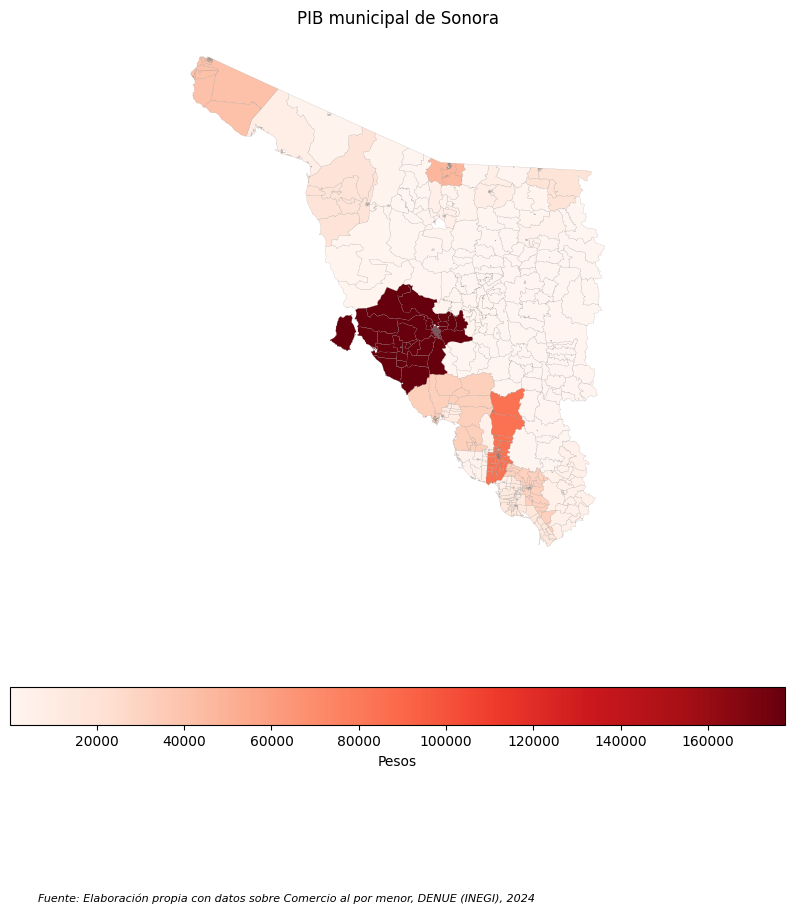

In [11]:
###############################################################################################
############################## PIB PÉR CÁPITA MUNICIPAL DE SONORA #############################
###############################################################################################
###############################################################################################
### PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal ###
###############################################################################################

#obtenemos la entidad federativa 
sonora = secciones[secciones['ENTIDAD'] == 26] #Sonora

#obtenemos los datos de Sonora
son = pib_data[pib_data['Nom_Entidad'] == 'Sonora']
#obtenemos el PIB estatal 
pib_sonora = son['PROMEDIO_PIB'] 

sonora['ENTIDAD'] = sonora['ENTIDAD'].astype(str)
censo['ENTIDAD'] = censo['ENTIDAD'].astype(str)

son_w_vars = sonora.merge(censo, left_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'], right_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'])
#poblacion municipal
poblacion_municipal = son_w_vars.groupby('MUNICIPIO')['POBTOT'].sum().reset_index()
poblacion_municipal  = poblacion_municipal.rename(columns = {"POBTOT":"pobMunicipio"})


son_w_vars = son_w_vars.merge(poblacion_municipal, on='MUNICIPIO', how='left')
#definimos la geometría del mapa
son_w_vars = gpd.GeoDataFrame(son_w_vars, geometry='geometry')

#obtenemos el PIB pér cápita municipal
### PIB pér cápita municipal = [(PIB estatal) / (población estatal )] * población municipal ###
son_w_vars['mun_pib'] = (pib_sonora[25] / son_w_vars['POBTOT'].sum())*son_w_vars['pobMunicipio']

#Graficamos el PIB municipal de Sonora obtenido 
fig, ax = plt.subplots(figsize=(10, 10))
son_w_vars.plot(column='mun_pib', ax=ax, cmap='Reds', legend=True, 
                edgecolor='grey', linewidth=0.1,
                legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB municipal de Sonora")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()

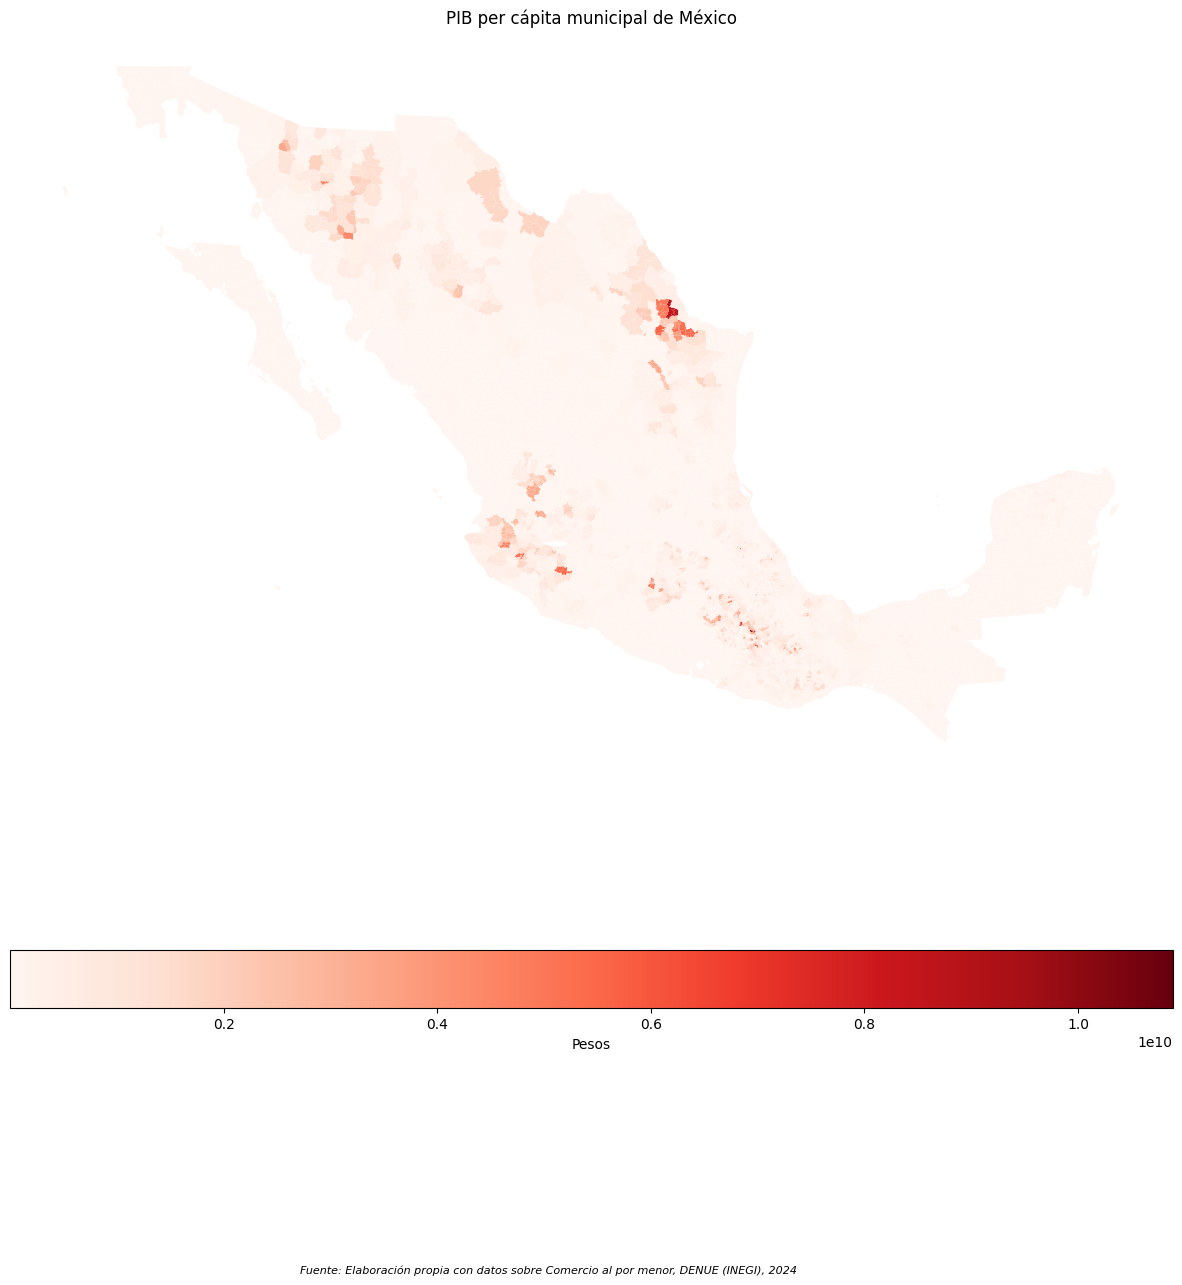

In [12]:
########################################################################################
############################# PIB PÉR CÁPITA POR MUNICIPIO #############################
########################################################################################

#Sabemos que el PIB pér cápita municipal está dado por: 
#PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal 

censo['ENTIDAD'] = censo['ENTIDAD'].astype(int)

#reducimos la tabla de censo a los datos que usaremos
censo_reducido = censo[['ENTIDAD', 'POBTOT', 'MUNICIPIO']]
#se agrupan datos con el objetivo de tener todos los datos por municipios, independentemente de la sección en la que se encuentren
censo_reducido = censo_reducido.groupby(['ENTIDAD', 'MUNICIPIO'])['POBTOT'].sum().reset_index()

#PIB estatal para las entidades federativas
pib_estatal = pib_data.groupby('ENTIDAD')['PROMEDIO_PIB'].sum().reset_index()

datos_completos = censo_reducido.merge(pib_estatal, left_on='ENTIDAD', right_on='ENTIDAD')

# Población total por municipio
poblacion_municipal = datos_completos.groupby(['ENTIDAD'])['POBTOT'].sum().reset_index()
poblacion_municipal = poblacion_municipal.rename(columns={"POBTOT": "pobMunicipio"})

datos_completos = datos_completos.merge(poblacion_municipal, left_on = 'ENTIDAD', right_on= 'ENTIDAD')
datos_completos['PIB_PER_CAPITA_MUNICIPAL'] = (datos_completos['PROMEDIO_PIB'] / datos_completos['POBTOT']) *datos_completos['pobMunicipio']
datos_completos = datos_completos.merge(secciones, left_on=['ENTIDAD', 'MUNICIPIO'], right_on=['ENTIDAD', 'MUNICIPIO'])

# Graficar el PIB per cápita municipal de todo el país
datos_completos = gpd.GeoDataFrame(datos_completos, geometry='geometry')
fig, ax = plt.subplots(figsize=(15, 15))
datos_completos.plot(column='PIB_PER_CAPITA_MUNICIPAL', ax=ax, cmap='Reds', 
                     legend=True, linewidth=0.1,
                     legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB per cápita municipal de México")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()


In [13]:
###############################################################################################
############################ MUNICIPIOS CON MAYOR PIB PER CÁPITA Y  ###########################
############################      ENTIDAD A LA QUE PERTENECEN       ###########################
###############################################################################################

datos_ordenados = datos_completos.sort_values(by='PIB_PER_CAPITA_MUNICIPAL', ascending=False)
lista_municipios = datos_ordenados[['ENTIDAD', 'MUNICIPIO', 'PIB_PER_CAPITA_MUNICIPAL']]

# Municipios con mayor PIB per cápita
print(lista_municipios.head(10))

#Como se puede observar, los 10 municipios con mayor PIB per cápita se encuentran en los estados de: Nuevo León, Oaxaca, Puebla
#A continuación, obtenemos el mapa de PIB per capita municipal de estos estados 

       ENTIDAD  MUNICIPIO  PIB_PER_CAPITA_MUNICIPAL
46080       20        396              1.088513e+10
46565       20        518              9.151213e+09
43742       19         41              8.542152e+09
43740       19         41              8.542152e+09
43741       19         41              8.542152e+09
46453       20        489              7.954516e+09
48800       21        136              7.163992e+09
46401       20        480              5.943029e+09
47664       21         97              5.797323e+09
41860       19         15              5.640453e+09


C:\Users\Mariela Mejia\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


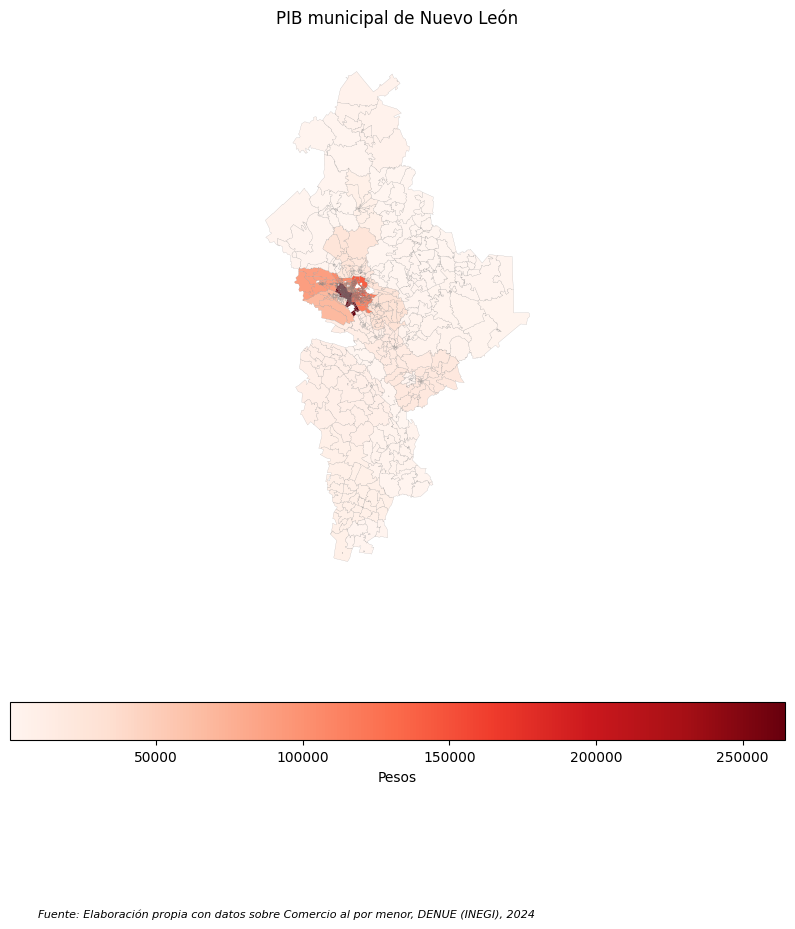

In [14]:
###############################################################################################
############################ PIB PÉR CÁPITA MUNICIPAL DE NUEVO LEÓN ###########################
###############################################################################################
###############################################################################################
### PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal ###
###############################################################################################

#obtenemos la entidad de Nuevo Leon
nl = secciones[secciones['ENTIDAD'] == 19] #Nuevo Leon

#obtenemos toda la información de Nuevo León
nuevoLeon = pib_data[pib_data['Nom_Entidad'] == 'Nuevo León']
#obtenemos el PIB estatal 
pib_nl = nuevoLeon['PROMEDIO_PIB'] 

nl['ENTIDAD'] = nl['ENTIDAD'].astype(str)
censo['ENTIDAD'] = censo['ENTIDAD'].astype(str)

nl_w_vars = nl.merge(censo, left_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'], right_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'])

#poblacion municipal
poblacion_municipal = nl_w_vars.groupby('MUNICIPIO')['POBTOT'].sum().reset_index()
poblacion_municipal  = poblacion_municipal.rename(columns = {"POBTOT":"pobMunicipio"})


nl_w_vars = nl_w_vars.merge(poblacion_municipal, on='MUNICIPIO', how='left')
#definimos la geometría del mapa
nl_w_vars = gpd.GeoDataFrame(nl_w_vars, geometry='geometry')

#obtenemos el PIB pér cápita municipal
### PIB pér cápita municipal = [(PIB estatal) / (población estatal )] * población municipal ###
nl_w_vars['mun_pib'] = (pib_nl[18] / nl_w_vars['POBTOT'].sum())*nl_w_vars['pobMunicipio']

#Graficamos el PIB municipal de Campeche obtenido 
fig, ax = plt.subplots(figsize=(10, 10))
nl_w_vars.plot(column='mun_pib', ax=ax, cmap='Reds', legend=True, 
               edgecolor='grey', linewidth=0.1,
               legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB municipal de Nuevo León")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()

C:\Users\Mariela Mejia\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


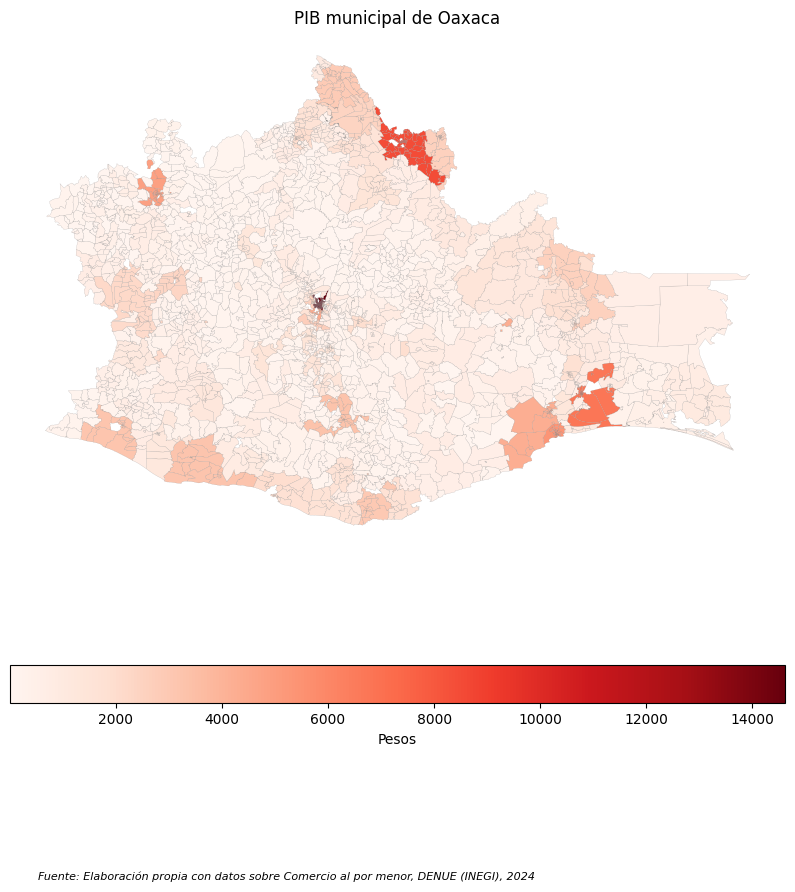

In [15]:
###############################################################################################
############################## PIB PÉR CÁPITA MUNICIPAL DE OAXACA #############################
###############################################################################################
###############################################################################################
### PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal ###
###############################################################################################

#obtenemos la entidad federativa
oax = secciones[secciones['ENTIDAD'] == 20] #Oaxaca

#obtenemos la informaicón de Oaxaca
oaxaca = pib_data[pib_data['Nom_Entidad'] == 'Oaxaca']
#obtenemos el PIB estatal 
pib_oaxaca = oaxaca['PROMEDIO_PIB'] 

oax['ENTIDAD'] = oax['ENTIDAD'].astype(str)
censo['ENTIDAD'] = censo['ENTIDAD'].astype(str)

oaxaca_w_vars = oax.merge(censo, left_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'], right_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'])
#poblacion municipal
poblacion_municipal = oaxaca_w_vars.groupby('MUNICIPIO')['POBTOT'].sum().reset_index()
poblacion_municipal  = poblacion_municipal.rename(columns = {"POBTOT":"pobMunicipio"})


oaxaca_w_vars = oaxaca_w_vars.merge(poblacion_municipal, on='MUNICIPIO', how='left')
#definimos la geometría del mapa
oaxaca_w_vars = gpd.GeoDataFrame(oaxaca_w_vars, geometry='geometry')

#obtenemos el PIB pér cápita municipal
### PIB pér cápita municipal = [(PIB estatal) / (población estatal )] * población municipal ###
oaxaca_w_vars['mun_pib'] = (pib_oaxaca[19] / oaxaca_w_vars['POBTOT'].sum())*oaxaca_w_vars['pobMunicipio']

#Graficamos el PIB municipal de Campeche obtenido 
fig, ax = plt.subplots(figsize=(10, 10))
oaxaca_w_vars.plot(column='mun_pib', ax=ax, cmap='Reds', legend=True, 
                   edgecolor='grey', linewidth=0.1,
                   legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB municipal de Oaxaca")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()

C:\Users\Mariela Mejia\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


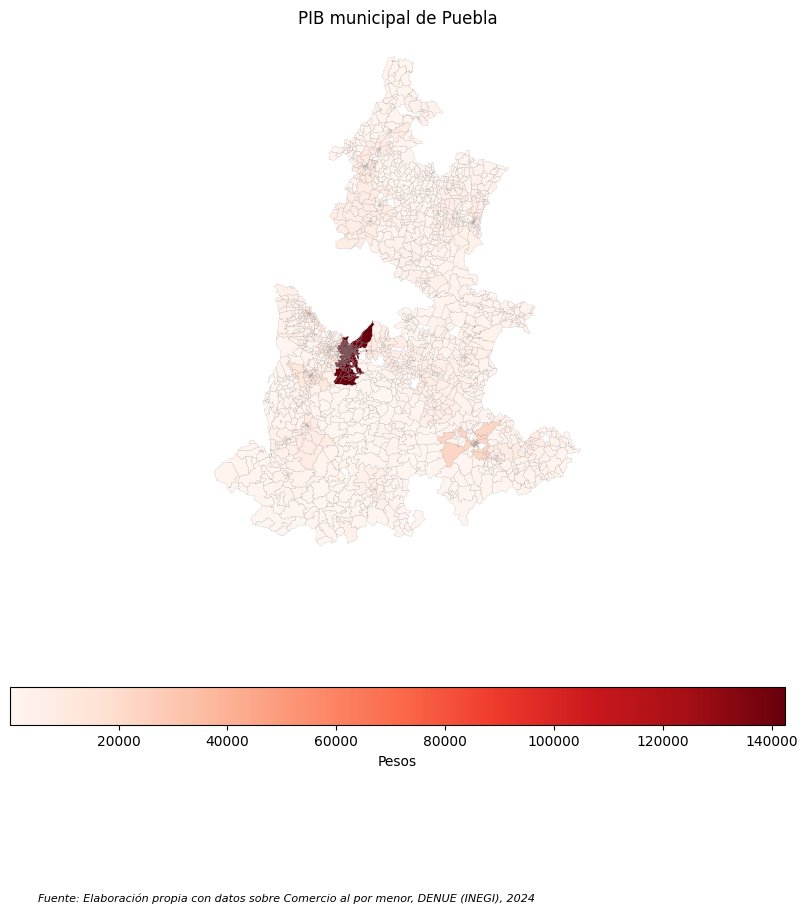

In [16]:
###############################################################################################
############################## PIB PÉR CÁPITA MUNICIPAL DE PUEBLA #############################
###############################################################################################
###############################################################################################
### PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal ###
###############################################################################################

#obtenemos la entidad federativa
pueb = secciones[secciones['ENTIDAD'] == 21] #Puebla

#obtenemos la información de Puebla
puebla = pib_data[pib_data['Nom_Entidad'] == 'Puebla']
#obtenemos el PIB estatal 
pib_puebla = puebla['PROMEDIO_PIB'] 

pueb['ENTIDAD'] = pueb['ENTIDAD'].astype(str)
censo['ENTIDAD'] = censo['ENTIDAD'].astype(str)

puebla_w_vars = pueb.merge(censo, left_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'], right_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'])
#poblacion municipal
poblacion_municipal = puebla_w_vars.groupby('MUNICIPIO')['POBTOT'].sum().reset_index()
poblacion_municipal  = poblacion_municipal.rename(columns = {"POBTOT":"pobMunicipio"})


puebla_w_vars = puebla_w_vars.merge(poblacion_municipal, on='MUNICIPIO', how='left')
#definimos la geometría del mapa
puebla_w_vars = gpd.GeoDataFrame(puebla_w_vars, geometry='geometry')

#obtenemos el PIB pér cápita municipal
### PIB pér cápita municipal = [(PIB estatal) / (población estatal )] * población municipal ###
puebla_w_vars['mun_pib'] = (pib_puebla[20] / puebla_w_vars['POBTOT'].sum())*puebla_w_vars['pobMunicipio']

#Graficamos el PIB municipal de Campeche obtenido 
fig, ax = plt.subplots(figsize=(10, 10))
puebla_w_vars.plot(column='mun_pib', ax=ax, cmap='Reds', legend=True, 
                   edgecolor='grey', linewidth=0.1,
                   legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB municipal de Puebla")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()

C:\Users\Mariela Mejia\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


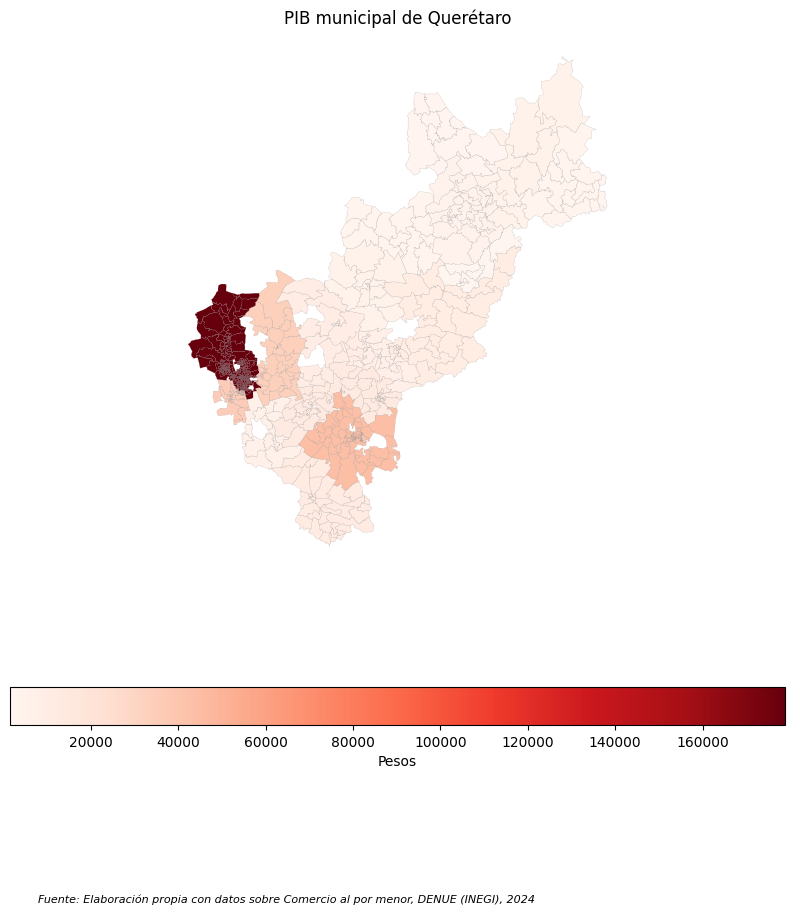

In [17]:
###############################################################################################
############################ PIB PÉR CÁPITA MUNICIPAL DE QUERETARO ############################
###############################################################################################
###############################################################################################
### PIB pér cápita municipal = [(PIB estatal) / (población estatal)] * población municipal ###
###############################################################################################

#obtenemos la entidad federativa 
quert = secciones[secciones['ENTIDAD'] == 22] #Queretaro

#obtenemos la información de la entidad 
queretaro = pib_data[pib_data['Nom_Entidad'] == 'Querétaro']
#obtenemos el PIB estatal 
pib_queretaro = queretaro['PROMEDIO_PIB'] 

quert['ENTIDAD'] = quert['ENTIDAD'].astype(str)
censo['ENTIDAD'] = censo['ENTIDAD'].astype(str)

quert_w_vars = quert.merge(censo, left_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'], right_on=['SECCION', 'ENTIDAD', 'MUNICIPIO'])
#poblacion municipal
poblacion_municipal = quert_w_vars.groupby('MUNICIPIO')['POBTOT'].sum().reset_index()
poblacion_municipal  = poblacion_municipal.rename(columns = {"POBTOT":"pobMunicipio"})


quert_w_vars = quert_w_vars.merge(poblacion_municipal, on='MUNICIPIO', how='left')

#definimos la geometría del mapa
quert_w_vars = gpd.GeoDataFrame(quert_w_vars, geometry='geometry')

#obtenemos el PIB pér cápita municipal
### PIB pér cápita municipal = [(PIB estatal) / (población estatal )] * población municipal ###
quert_w_vars['mun_pib'] = (pib_queretaro[21] / quert_w_vars['POBTOT'].sum())*quert_w_vars['pobMunicipio']

#Graficamos el PIB municipal de Campeche obtenido 
fig, ax = plt.subplots(figsize=(10, 10))
quert_w_vars.plot(column='mun_pib', ax=ax, cmap='Reds', legend=True, 
                  edgecolor='grey', linewidth=0.1,
                  legend_kwds={'label': 'Pesos', 'orientation': 'horizontal'})
ax.set_axis_off()
plt.title("PIB municipal de Querétaro")
plt.figtext(0.65, 0.01, "Fuente: Elaboración propia con datos sobre PIB, INEGI, 2024", 
            ha="right", fontsize=8, style='italic')
plt.show()